#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работ:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



## Подготовка

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
pd.options.mode.chained_assignment = None
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor

Сперва откроем и посмотрим на данные.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0]) 

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.index.is_monotonic

True

У нас всего 2 столбца с количеством заказов и датами. Данные идут через каждые 10 минут. Ресемплируем по одному часу и отсортируем.

In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [6]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

У нас имеются данные с 03 марта 2018 года по 31 августа 2018. Для анализа построим график со скользящим средним и изучим тренд и сезонность.

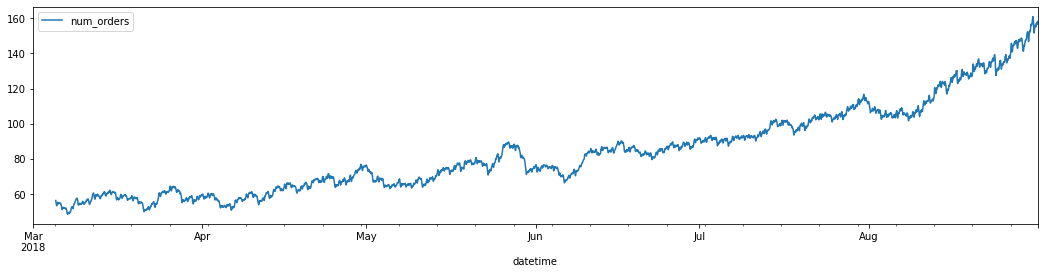

In [8]:
data.rolling(100).mean().plot(figsize=(18,4)); # скользящее среднее

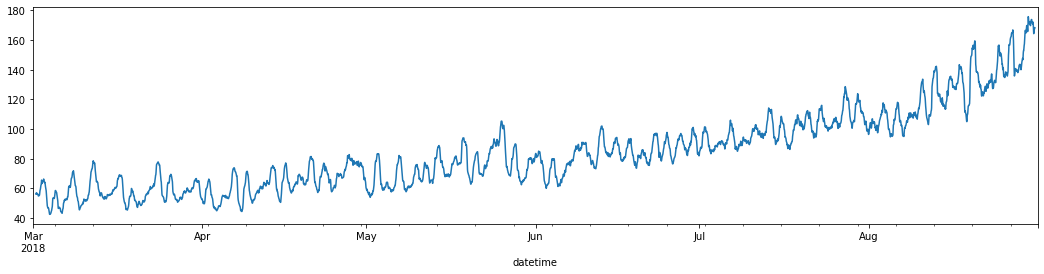

In [9]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(figsize=(18,4)); # график тренда

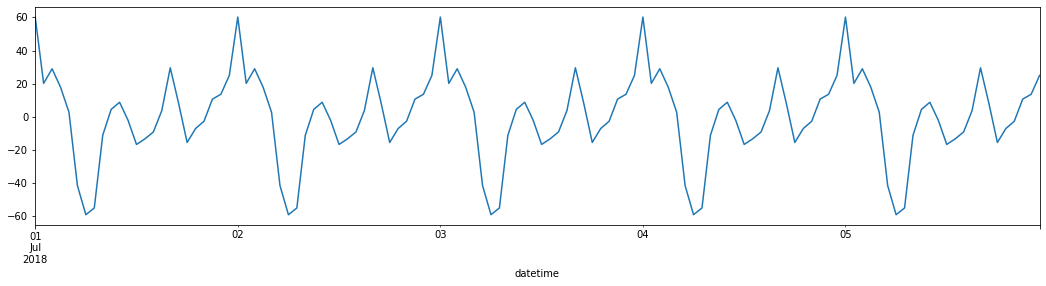

In [10]:
decomposed.seasonal['2018-07-01':'2018-07-05'].plot(figsize=(18,4)); # график сезонности летом

По графику скользящей средней видим, что перед нами нестационарный временной ряд. С течением времени средняя у графика увеличивается. По графику тренда тоже заметно, что к лету среднее количество заказов такси значительно растет. По графику сезонности можем увидеть, как распределение меняяется в течение суток. Основной пик по заказам приходится на вечер и достигает нижней точки только ночью.

## Обучение

Разделим модель на тренировочную, валидацинную и тестовую выборки. Дальше добавим несколько признаков и попробуем подобрать лучшую модель по RMSE.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [12]:
make_features(data, 27, 15)

In [13]:
train, te = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(te, shuffle=False, test_size=0.5)
train = train.dropna()
valid = valid.dropna()
test = test.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'],axis=1)
target_valid = valid['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

In [14]:
te.shape

(884, 33)

In [15]:
train.shape

(3505, 33)

In [16]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [17]:
#RMSE линейная регрессия
prediction_valid = model.predict(features_valid)
print("RMSE валидационной выборки: ", mean_squared_error(target_valid, prediction_valid)**0.5)

RMSE валидационной выборки:  34.005785782495956


In [18]:
# CatBoost
tss = TimeSeriesSplit()
catboost_model = CatBoostRegressor(iterations=100, loss_function='RMSE')
catboost_model.fit(features_train, target_train, verbose=10)
catboost_predictions = catboost_model.predict(features_valid)

Learning rate set to 0.324519
0:	learn: 31.2580873	total: 55.8ms	remaining: 5.53s
10:	learn: 22.1124943	total: 122ms	remaining: 988ms
20:	learn: 20.3226174	total: 209ms	remaining: 787ms
30:	learn: 19.0890062	total: 304ms	remaining: 676ms
40:	learn: 17.9268902	total: 371ms	remaining: 534ms
50:	learn: 16.7329350	total: 443ms	remaining: 425ms
60:	learn: 15.6604137	total: 504ms	remaining: 322ms
70:	learn: 14.9079482	total: 565ms	remaining: 231ms
80:	learn: 14.3394364	total: 624ms	remaining: 146ms
90:	learn: 13.7061166	total: 687ms	remaining: 68ms
99:	learn: 13.2375770	total: 748ms	remaining: 0us


In [19]:
#RMSE CatBoost
print("RMSE валидационной выборки: ", mean_squared_error(catboost_predictions, target_valid)**0.5)

RMSE валидационной выборки:  33.14531484376472


In [20]:
%%time
#RandomizedSearchCV рандомного леса
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50)]
max_depth = [int(x) for x in np.linspace(1, 20)]
rfr_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
model_rfr = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = rfr_grid, cv = tss, scoring = 'neg_root_mean_squared_error')
model_rfr.fit(features_train, target_train)
forest_predictions = model_rfr.predict(features_valid)

CPU times: user 22.6 s, sys: 57.2 ms, total: 22.7 s
Wall time: 22.7 s


In [21]:
#RMSE Лес
print("RMSE валидационной выборки: ", mean_squared_error(forest_predictions, target_valid)**0.5)

RMSE валидационной выборки:  33.41459671178789


Мы попробовали подобрать модель с разными переменными, у линейной регрессии rmse получился 33.0, у catboost 33.14, у рандомного леса 33.167

In [23]:
cross_val_score(catboost_model, catboost_predictions, target_valid, cv=tss, scoring = 'neg_root_mean_squared_error')

Learning rate set to 0.177519
0:	learn: 41.0120429	total: 245us	remaining: 24.3ms
1:	learn: 38.2672062	total: 605us	remaining: 29.7ms
2:	learn: 36.0251269	total: 915us	remaining: 29.6ms
3:	learn: 34.2772243	total: 1.11ms	remaining: 26.6ms
4:	learn: 32.3687249	total: 1.41ms	remaining: 26.7ms
5:	learn: 31.2341052	total: 1.7ms	remaining: 26.7ms
6:	learn: 30.2662790	total: 1.96ms	remaining: 26ms
7:	learn: 29.4395935	total: 2.39ms	remaining: 27.5ms
8:	learn: 28.5453974	total: 2.6ms	remaining: 26.3ms
9:	learn: 28.0621070	total: 2.75ms	remaining: 24.7ms
10:	learn: 27.6555709	total: 2.92ms	remaining: 23.6ms
11:	learn: 27.3804491	total: 3.06ms	remaining: 22.5ms
12:	learn: 27.0360126	total: 3.2ms	remaining: 21.4ms
13:	learn: 26.7728041	total: 3.36ms	remaining: 20.7ms
14:	learn: 26.4093808	total: 3.52ms	remaining: 20ms
15:	learn: 26.1287041	total: 3.68ms	remaining: 19.3ms
16:	learn: 25.9650096	total: 3.77ms	remaining: 18.4ms
17:	learn: 25.8085471	total: 3.92ms	remaining: 17.9ms
18:	learn: 25.6921

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 335, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File 

Learning rate set to 0.197243
0:	learn: 38.3686114	total: 342us	remaining: 33.9ms
1:	learn: 35.3620426	total: 705us	remaining: 34.6ms
2:	learn: 33.3250672	total: 952us	remaining: 30.8ms
3:	learn: 31.5234253	total: 1.17ms	remaining: 28.2ms
4:	learn: 30.0482783	total: 1.39ms	remaining: 26.4ms
5:	learn: 29.0140443	total: 1.67ms	remaining: 26.1ms
6:	learn: 28.1836506	total: 1.88ms	remaining: 25ms
7:	learn: 27.6279434	total: 2.08ms	remaining: 23.9ms
8:	learn: 27.3074364	total: 2.29ms	remaining: 23.2ms
9:	learn: 26.9645055	total: 2.49ms	remaining: 22.4ms
10:	learn: 26.6739043	total: 2.72ms	remaining: 22ms
11:	learn: 26.4804782	total: 2.91ms	remaining: 21.3ms
12:	learn: 26.2599998	total: 3.09ms	remaining: 20.7ms
13:	learn: 26.1177916	total: 3.38ms	remaining: 20.8ms
14:	learn: 25.9927172	total: 3.7ms	remaining: 21ms
15:	learn: 25.9267271	total: 3.96ms	remaining: 20.8ms
16:	learn: 25.8809839	total: 4.08ms	remaining: 19.9ms
17:	learn: 25.7680686	total: 4.27ms	remaining: 19.5ms
18:	learn: 25.7083

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 335, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File 

Learning rate set to 0.209996
0:	learn: 38.0023212	total: 453us	remaining: 44.9ms
1:	learn: 35.1654657	total: 880us	remaining: 43.1ms
2:	learn: 32.8092696	total: 1.29ms	remaining: 41.8ms
3:	learn: 31.3395615	total: 1.63ms	remaining: 39.2ms
4:	learn: 30.0558079	total: 1.99ms	remaining: 37.8ms
5:	learn: 29.3298105	total: 2.28ms	remaining: 35.7ms
6:	learn: 28.6853804	total: 2.58ms	remaining: 34.3ms
7:	learn: 28.2072953	total: 2.92ms	remaining: 33.5ms
8:	learn: 27.8880349	total: 3.17ms	remaining: 32.1ms
9:	learn: 27.6049759	total: 3.47ms	remaining: 31.2ms
10:	learn: 27.3905393	total: 3.75ms	remaining: 30.4ms
11:	learn: 27.2479909	total: 4.11ms	remaining: 30.2ms
12:	learn: 27.0766650	total: 4.4ms	remaining: 29.4ms
13:	learn: 26.9714603	total: 4.68ms	remaining: 28.8ms
14:	learn: 26.9197408	total: 4.98ms	remaining: 28.2ms
15:	learn: 26.8283971	total: 5.31ms	remaining: 27.9ms
16:	learn: 26.7381248	total: 5.61ms	remaining: 27.4ms
17:	learn: 26.7155496	total: 5.92ms	remaining: 27ms
18:	learn: 26

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 335, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File 

Learning rate set to 0.219606
0:	learn: 37.4108982	total: 421us	remaining: 41.7ms
1:	learn: 34.0850152	total: 907us	remaining: 44.5ms
2:	learn: 31.7970588	total: 1.29ms	remaining: 41.9ms
3:	learn: 30.2146163	total: 1.63ms	remaining: 39.2ms
4:	learn: 29.0208137	total: 1.95ms	remaining: 37ms
5:	learn: 28.1805193	total: 2.28ms	remaining: 35.8ms
6:	learn: 27.6136348	total: 2.64ms	remaining: 35.1ms
7:	learn: 27.2535001	total: 2.96ms	remaining: 34ms
8:	learn: 26.8996750	total: 3.29ms	remaining: 33.2ms
9:	learn: 26.6318333	total: 3.6ms	remaining: 32.4ms
10:	learn: 26.5086511	total: 3.95ms	remaining: 31.9ms
11:	learn: 26.3951311	total: 4.28ms	remaining: 31.4ms
12:	learn: 26.2365400	total: 4.6ms	remaining: 30.8ms
13:	learn: 26.1396143	total: 4.94ms	remaining: 30.3ms
14:	learn: 26.0596234	total: 5.4ms	remaining: 30.6ms
15:	learn: 25.9435159	total: 5.81ms	remaining: 30.5ms
16:	learn: 25.9077575	total: 6.05ms	remaining: 29.5ms
17:	learn: 25.8314655	total: 6.39ms	remaining: 29.1ms
18:	learn: 25.782

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 335, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File 

Learning rate set to 0.227389
0:	learn: 37.6270200	total: 474us	remaining: 47ms
1:	learn: 34.1694237	total: 861us	remaining: 42.2ms
2:	learn: 31.7297173	total: 1.37ms	remaining: 44.4ms
3:	learn: 29.9844894	total: 1.74ms	remaining: 41.7ms
4:	learn: 28.9336095	total: 2.13ms	remaining: 40.6ms
5:	learn: 28.0931691	total: 2.46ms	remaining: 38.6ms
6:	learn: 27.6036401	total: 2.86ms	remaining: 38ms
7:	learn: 27.3494890	total: 3.31ms	remaining: 38.1ms
8:	learn: 27.0201554	total: 3.71ms	remaining: 37.5ms
9:	learn: 26.8232389	total: 4.14ms	remaining: 37.3ms
10:	learn: 26.6861527	total: 4.55ms	remaining: 36.8ms
11:	learn: 26.6122108	total: 4.93ms	remaining: 36.2ms
12:	learn: 26.5279372	total: 5.28ms	remaining: 35.3ms
13:	learn: 26.4750879	total: 5.71ms	remaining: 35.1ms
14:	learn: 26.4202087	total: 6.04ms	remaining: 34.2ms
15:	learn: 26.3724382	total: 6.41ms	remaining: 33.7ms
16:	learn: 26.3250859	total: 6.61ms	remaining: 32.3ms
17:	learn: 26.2513139	total: 6.98ms	remaining: 31.8ms
18:	learn: 26.

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 335, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File 

array([nan, nan, nan, nan, nan])

## Тестирование

Попробуем модель рандомного леса на тестовой выборке.

In [24]:
prediction_test_linear = model.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(prediction_test_linear, target_test)**0.5)

RMSE тестовой выборки:  46.96464763549852


In [25]:
prediction_test_cat = catboost_model.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(prediction_test_cat, target_test)**0.5)

RMSE тестовой выборки:  55.73579595813513


In [26]:
prediction_test_rfr = model_rfr.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(prediction_test_rfr, target_test)**0.5)

RMSE тестовой выборки:  50.08538430156338


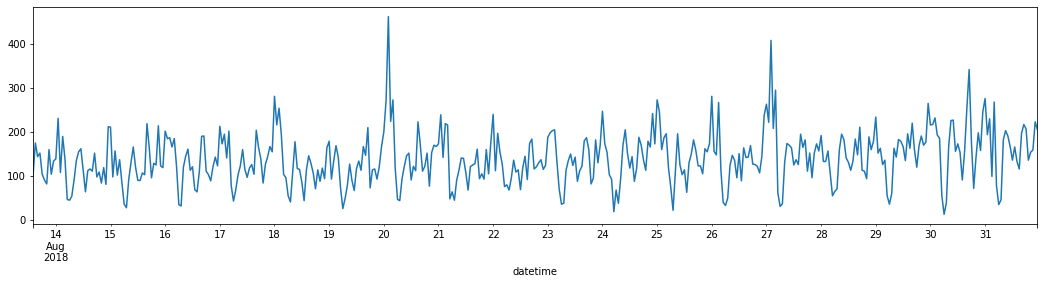

In [27]:
# исходный ряд
target_test.plot(figsize=(18,4));

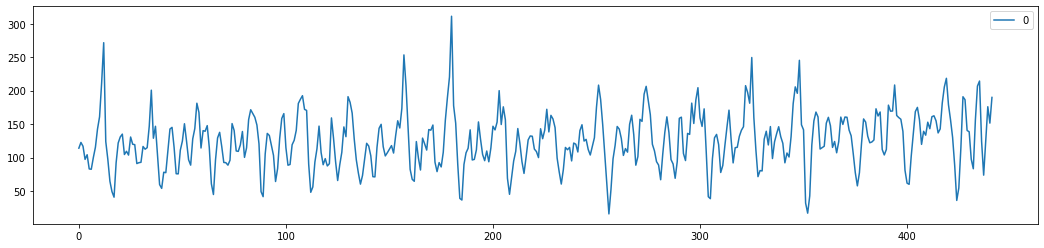

In [28]:
# прогнозируемый ряд
prediction_test_linear = pd.DataFrame(prediction_test_linear)
prediction_test_linear.plot(figsize=(18,4));

In [29]:
prediction_test_linear = prediction_test_linear.reset_index()
target_test = target_test.reset_index()

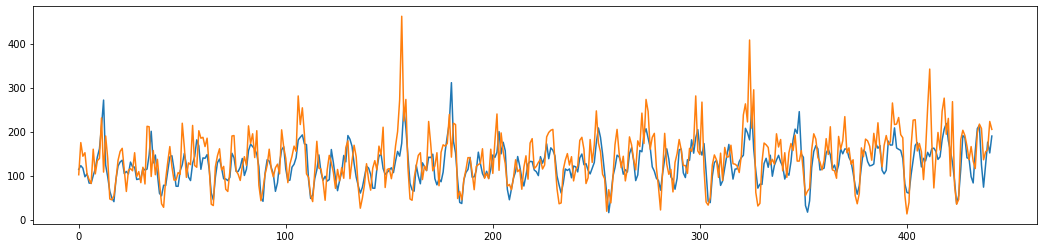

In [30]:
# не получалось сначала, потом после ресета индекса сработало. Убрал сглаживание.
prediction_test_linear[0].plot(figsize=(18,4));
target_test['num_orders'].plot(figsize=(18,4));